<a href="https://colab.research.google.com/github/samuelaojih/Google-Colab/blob/main/Ungoverned_Spaces_Plateau_Bauchi_States.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload files containing 'ACLED_Conflict' and 'ungoverned' in their names.


Saving ungoverned.csv to ungoverned.csv
Saving ACLED_Conflict.csv to ACLED_Conflict.csv

--- ACLED Structure ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1808 entries, 0 to 1807
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FID                   1808 non-null   int64  
 1   event_id_c            1808 non-null   object 
 2   event_date            1808 non-null   object 
 3   year                  1808 non-null   int64  
 4   time_preci            1808 non-null   int64  
 5   disorder_t            1808 non-null   object 
 6   event_type            1808 non-null   object 
 7   sub_event_            1808 non-null   object 
 8   actor1                1808 non-null   object 
 9   assoc_acto            1808 non-null   object 
 10  inter1                1808 non-null   object 
 11  actor2                1808 non-null   object 
 12  assoc_ac_1            1808 non-null   object 
 13  inter2    

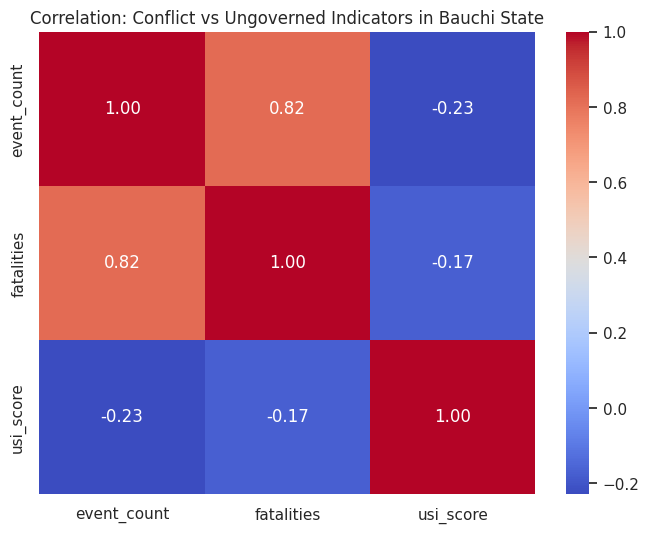

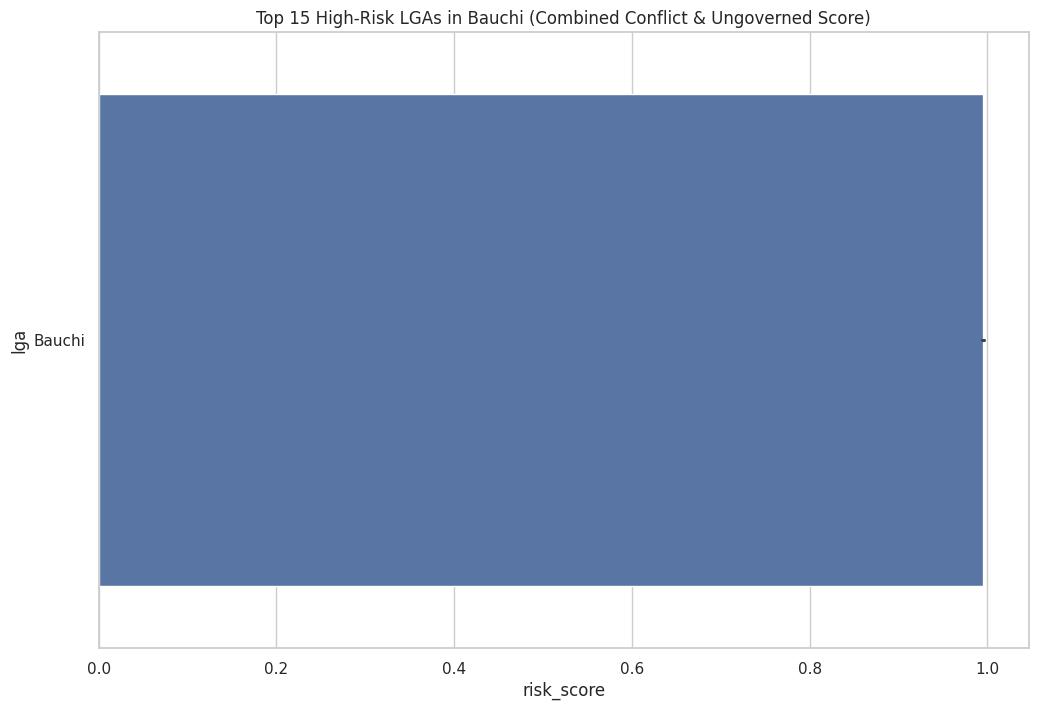

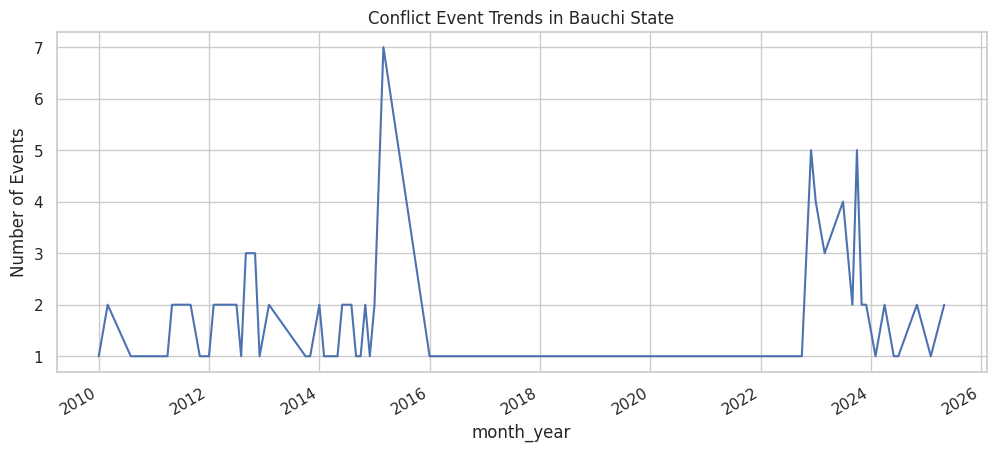


Analyzing Plateau State...
Running statistical tests...
Generating Plots for Plateau...


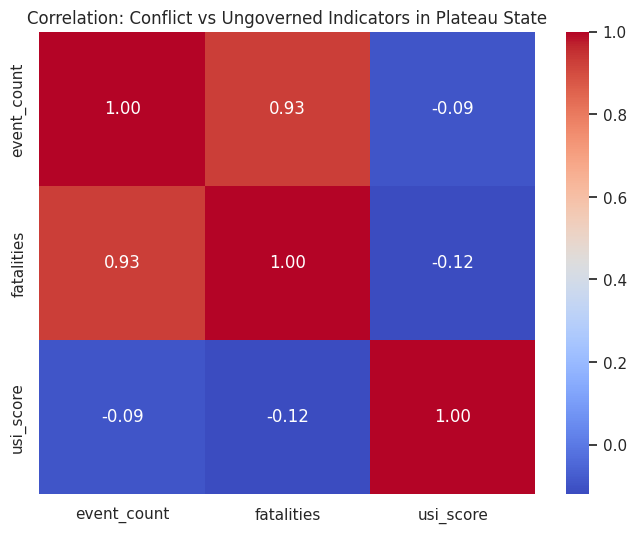

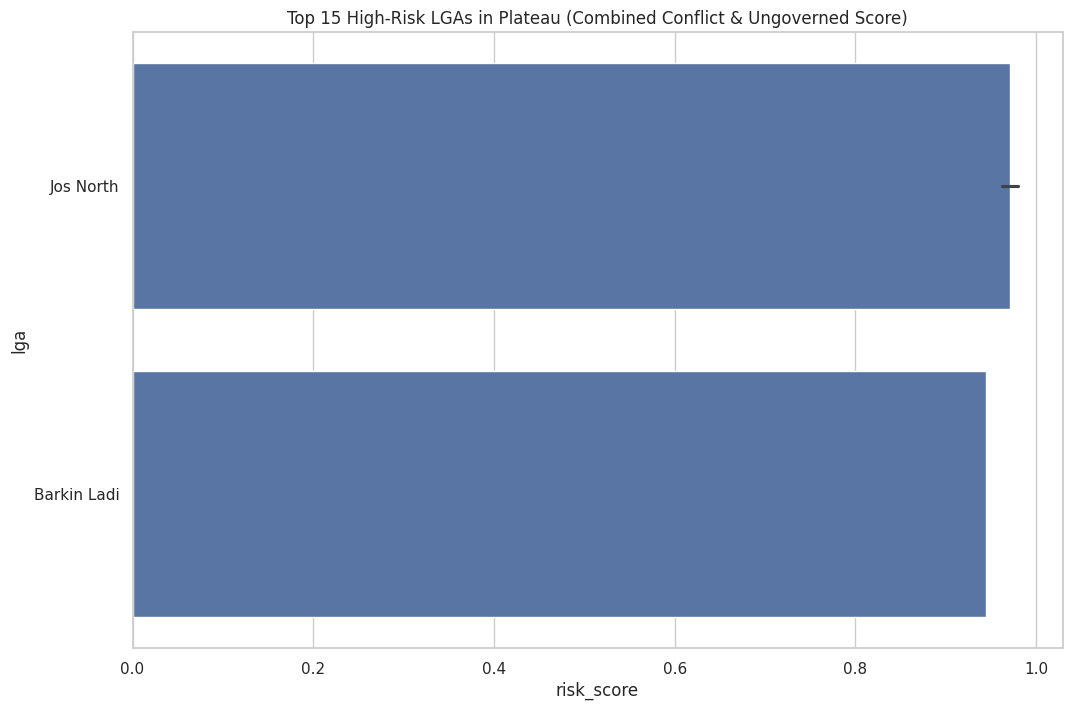

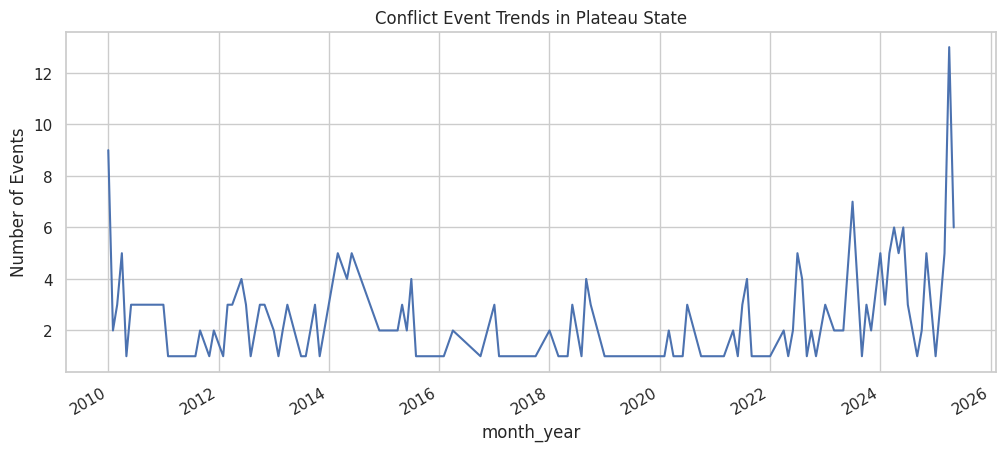


Exporting data...
Files saved: ACLED_Cleaned.csv, Ungoverned_Cleaned.csv, Merged_Conflict_Ungoverned.csv

COMPREHENSIVE ANALYSIS SUMMARY

--- Bauchi State Summary ---
Total Events: 123,419
Total Fatalities: 555,105
Pearson Correlation (USI vs Events): -0.228 (p=0.0000)
Top 5 High-Risk LGAs in Bauchi:
  - Bauchi (Risk Score: 0.999)
  - Bauchi (Risk Score: 0.998)
  - Bauchi (Risk Score: 0.998)
  - Bauchi (Risk Score: 0.997)
  - Bauchi (Risk Score: 0.997)

--- Plateau State Summary ---
Total Events: 25,328
Total Fatalities: 97,392
Pearson Correlation (USI vs Events): -0.094 (p=0.0000)
Top 5 High-Risk LGAs in Plateau:
  - Jos North (Risk Score: 0.998)
  - Jos North (Risk Score: 0.997)
  - Jos North (Risk Score: 0.996)
  - Jos North (Risk Score: 0.994)
  - Jos North (Risk Score: 0.979)
Files saved per state: correlation_heatmap_{state}.png, risk_lga_bar_{state}.png, conflict_trends_{state}.png


In [1]:
# ==========================================
# 1. LOAD REQUIRED LIBRARIES
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import os
from google.colab import files

# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ==========================================e
# 2. HELPER FUNCTIONS
# ==========================================e
def load_datasets(acled_filename_hint='ACLED_Conflict', ungoverned_filename_hint='ungoverned'):
    """Loads ACLED and ungoverned spaces datasets, inferring actual filenames from upload."""
    print(f"Please upload files containing '{acled_filename_hint}' and '{ungoverned_filename_hint}' in their names.")
    uploaded = files.upload()

    df_acled = None
    df_gov = None

    acled_actual_filename = None
    ungoverned_actual_filename = None

    # Find the actual uploaded filenames based on hints
    for f in uploaded.keys():
        if acled_filename_hint.lower() in f.lower() and acled_actual_filename is None:
            acled_actual_filename = f
        if ungoverned_filename_hint.lower() in f.lower() and ungoverned_actual_filename is None:
            ungoverned_actual_filename = f

    if not acled_actual_filename:
        print(f"Error: No file containing '{acled_filename_hint}' found among uploaded files.")
        return None, None
    if not ungoverned_actual_filename:
        print(f"Error: No file containing '{ungoverned_filename_hint}' found among uploaded files.")
        return None, None

    # Load ACLED data
    try:
        if acled_actual_filename.lower().endswith('.csv'):
            df_acled = pd.read_csv(acled_actual_filename)
        elif acled_actual_filename.lower().endswith(('.xls', '.xlsx')):
            df_acled = pd.read_excel(acled_actual_filename)
        else:
            print(f"Error: Unsupported file format for ACLED data: {acled_actual_filename}")
            return None, None
    except Exception as e:
        print(f"Error loading ACLED data from {acled_actual_filename}: {e}")
        return None, None

    # Load ungoverned data
    try:
        if ungoverned_actual_filename.lower().endswith('.csv'):
            df_gov = pd.read_csv(ungoverned_actual_filename)
        elif ungoverned_actual_filename.lower().endswith(('.xls', '.xlsx')):
            df_gov = pd.read_excel(ungoverned_actual_filename)
        else:
            print(f"Error: Unsupported file format for ungoverned data: {ungoverned_actual_filename}")
            return None, None
    except Exception as e:
        print(f"Error loading ungoverned data from {ungoverned_actual_filename}: {e}")
        return None, None

    print("\n--- ACLED Structure ---")
    print(df_acled.info())
    print("\n--- Ungoverned Data Structure ---")
    print(df_gov.info())
    return df_acled, df_gov

def clean_acled_data(df_acled):
    """Cleans and preprocesses ACLED conflict data for all states."""
    print("\nCleaning ACLED data...")
    df_acled_cleaned = df_acled.copy()

    # Standardize columns
    df_acled_cleaned.columns = df_acled_cleaned.columns.str.strip().str.lower().str.replace(' ', '_')

    # Filter by specific event types
    # Ensure event_type is a string type for comparison
    df_acled_cleaned['event_type'] = df_acled_cleaned['event_type'].astype(str)
    df_acled_cleaned = df_acled_cleaned[df_acled_cleaned['event_type'].isin(['Battles', 'Explosions/Remote violence'])]

    # Date conversion
    df_acled_cleaned['event_date'] = pd.to_datetime(df_acled_cleaned['event_date'], errors='coerce')
    df_acled_cleaned = df_acled_cleaned.dropna(subset=['event_date']) # Drop rows where date conversion failed
    df_acled_cleaned['year'] = df_acled_cleaned['event_date'].dt.year
    df_acled_cleaned['month_year'] = df_acled_cleaned['event_date'].dt.to_period('M')

    # Clean LGA names (Admin2)
    df_acled_cleaned['admin2'] = df_acled_cleaned['admin2'].str.strip().str.title()

    # Handle missing values
    df_acled_cleaned['fatalities'] = df_acled_cleaned['fatalities'].fillna(0)

    # Derived Variables
    df_acled_cleaned['event_count'] = 1

    # Drop irrelevant columns (subsetting for analysis)
    keep_cols = ['event_date', 'year', 'month_year', 'event_type', 'admin1', 'admin2', 'fatalities', 'event_count', 'latitude', 'longitude']
    df_acled_cleaned = df_acled_cleaned[keep_cols]

    return df_acled_cleaned

def clean_ungoverned_data(df_gov, indicators=None):
    """Cleans and preprocesses ungoverned spaces data and computes USI for all states."""
    print("Cleaning governance data...")
    df_gov_cleaned = df_gov.copy()

    # Identify potential state and lga columns before generic standardization
    state_col_map = {'state name': 'state', 'statename': 'state'}
    lga_col_map = {'lga name': 'lga', 'lganame': 'lga'}

    found_state_col_original = None
    found_lga_col_original = None

    # Find actual column names in the raw data, ignoring case and spaces initially for identification
    for col in df_gov_cleaned.columns:
        col_lower_stripped = col.strip().lower()
        if col_lower_stripped in state_col_map and found_state_col_original is None:
            found_state_col_original = col
        if col_lower_stripped in lga_col_map and found_lga_col_original is None:
            found_lga_col_original = col

    if found_state_col_original:
        df_gov_cleaned.rename(columns={found_state_col_original: 'state'}, inplace=True)
    else:
        print("Error: Could not identify a 'state' column (e.g., 'State Name', 'statename') in ungoverned data.")
        return pd.DataFrame() # Return empty DataFrame to prevent further errors

    if found_lga_col_original:
        df_gov_cleaned.rename(columns={found_lga_col_original: 'lga'}, inplace=True)
    else:
        print("Error: Could not identify an 'lga' column (e.g., 'LGA Name', 'lganame') in ungoverned data.")
        return pd.DataFrame()

    # Standardize remaining columns, including the new 'state' and 'lga' columns just in case they still have spaces
    df_gov_cleaned.columns = df_gov_cleaned.columns.str.strip().str.lower().str.replace(' ', '_')

    # Clean LGA names (Admin2) - now using 'lga' which is also standardized
    df_gov_cleaned['lga'] = df_gov_cleaned['lga'].str.strip().str.title() # Title case for display/matching

    # Handle missing indicators with median
    numeric_cols = df_gov_cleaned.select_dtypes(include=[np.number]).columns
    if not numeric_cols.empty:
        df_gov_cleaned[numeric_cols] = df_gov_cleaned[numeric_cols].apply(lambda x: x.fillna(x.median()))

    # Composite Ungoverned Space Index (USI)
    scaler = MinMaxScaler()
    if indicators and all(col in df_gov_cleaned.columns for col in indicators):
        df_gov_cleaned['usi_raw'] = df_gov_cleaned[indicators].mean(axis=1)
    else:
        print("Warning: Specific indicator columns not found. Creating synthetic USI from all numeric columns for demonstration.")
        # Exclude 'objectid', 'longitude', 'latitude' if they exist and are not meant for USI calculation
        usi_calc_cols = df_gov_cleaned.select_dtypes(include=np.number).columns.drop(['objectid', 'longitude', 'latitude'], errors='ignore')
        if not usi_calc_cols.empty:
            df_gov_cleaned['usi_raw'] = df_gov_cleaned[usi_calc_cols].mean(axis=1)
        else:
            df_gov_cleaned['usi_raw'] = 0 # Fallback if no numeric columns for USI

    if not df_gov_cleaned['usi_raw'].isnull().all():
        df_gov_cleaned['usi_score'] = scaler.fit_transform(df_gov_cleaned[['usi_raw']])
    else:
        df_gov_cleaned['usi_score'] = 0.0 # Assign a default if USI raw is all null

    return df_gov_cleaned

def merge_datasets(df_acled_cleaned, df_gov_cleaned):
    """Aggregates ACLED data and merges with governance data."""
    print("Merging datasets...")

    # Aggregate ACLED by LGA (admin1=state, admin2=lga)
    acled_agg = df_acled_cleaned.groupby(['admin1', 'admin2']).agg({
        'event_count': 'sum',
        'fatalities': 'sum'
    }).reset_index()

    # Rename for merging
    acled_agg.rename(columns={'admin1': 'state', 'admin2': 'lga'}, inplace=True)

    # Merge
    df_merged = pd.merge(acled_agg, df_gov_cleaned, on=['state', 'lga'], how='inner')

    # Identify misses
    unmatched = acled_agg[~acled_agg['lga'].isin(df_merged['lga'])]
    if not unmatched.empty:
        print(f"Alert: {len(unmatched)} LGAs from ACLED data did not match in ungoverned.csv. Check spelling.")

    return df_merged

def analyze_state_data(df_state):
    """Performs correlation analysis and feature engineering for a given state's data."""
    print("Running statistical tests...")

    # Correlation Matrix
    corr_matrix = df_state[['event_count', 'fatalities', 'usi_score']].corr(method='pearson')

    # P-Values
    try:
        pearson_r, p_val = pearsonr(df_state['usi_score'], df_state['event_count'])
    except ValueError:
        pearson_r, p_val = np.nan, np.nan # Handle cases with insufficient data for correlation

    # Conflict Density (Events relative to USI)
    df_state['conflict_density_idx'] = df_state['event_count'] * df_state['usi_score']

    # Ungoverned Risk Score (Normalized)
    df_state['risk_score'] = (df_state['event_count'].rank(pct=True, method='dense') +
                              df_state['usi_score'].rank(pct=True, method='dense')) / 2

    return df_state, corr_matrix, pearson_r, p_val

def generate_state_plots(df_state, corr_matrix, state_name, df_acled_cleaned_all):
    """Generates and saves state-specific visualizations."""
    print(f"Generating Plots for {state_name}...")

    # Plot 1: Correlation Heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation: Conflict vs Ungoverned Indicators in {state_name} State')
    plt.savefig(f'correlation_heatmap_{state_name}.png')
    plt.show()
    plt.close()

    # Plot 2: Risk by LGA
    plt.figure(figsize=(12,8))
    # Ensure we have enough data for top_risk, otherwise plot all available
    num_top_risk = min(15, len(df_state))
    if num_top_risk > 0:
        top_risk = df_state.sort_values('risk_score', ascending=False).head(num_top_risk)
        sns.barplot(data=top_risk, x='risk_score', y='lga') # Removed palette to avoid FutureWarning
        plt.title(f'Top {num_top_risk} High-Risk LGAs in {state_name} (Combined Conflict & Ungoverned Score)')
        plt.savefig(f'risk_lga_bar_{state_name}.png')
        plt.show()
        plt.close()
    else:
        print(f"No sufficient data to plot high-risk LGAs for {state_name}.")

    # Plot 3: ACLED Trends (using original cleaned ACLED data, filtered by state)
    plt.figure(figsize=(12,5))
    df_acled_state_filtered = df_acled_cleaned_all[df_acled_cleaned_all['admin1'] == state_name].copy()
    if not df_acled_state_filtered.empty:
        # Ensure month_year is treated correctly as a period for plotting
        conflict_trend_data = df_acled_state_filtered.groupby('month_year')['event_count'].sum()
        if not conflict_trend_data.empty:
            # Convert PeriodIndex to datetime for plotting
            conflict_trend_data.index = conflict_trend_data.index.to_timestamp()
            conflict_trend_data.plot()
            plt.title(f'Conflict Event Trends in {state_name} State')
            plt.ylabel('Number of Events')
            plt.savefig(f'conflict_trends_{state_name}.png')
            plt.show()
            plt.close()
        else:
            print(f"No conflict event trend data available for {state_name}.")
    else:
        print(f"No ACLED data found for {state_name} to plot trends.")

def export_processed_data(df_acled_cleaned, df_gov_cleaned, df_merged):
    """Exports cleaned and merged dataframes to CSV."""
    print("\nExporting data...")
    df_acled_cleaned.to_csv('ACLED_Cleaned.csv', index=False)
    df_gov_cleaned.to_csv('Ungoverned_Cleaned.csv', index=False)
    df_merged.to_csv('Merged_Conflict_Ungoverned.csv', index=False)
    print("Files saved: ACLED_Cleaned.csv, Ungoverned_Cleaned.csv, Merged_Conflict_Ungoverned.csv")

def print_comprehensive_summary(state_summaries, default_usi_warning=False):
    """Prints a comprehensive summary of the analysis."""
    print("\n" + "="*30)
    print("COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*30)

    for state, summary in state_summaries.items():
        print(f"\n--- {state} State Summary ---")
        print(f"Total Events: {summary['total_events']:,}")
        print(f"Total Fatalities: {summary['total_fatalities']:,}")
        print(f"Pearson Correlation (USI vs Events): {summary['usi_event_pearson_r']:.3f} (p={summary['usi_event_p_val']:.4f})")
        print(f"Top 5 High-Risk LGAs in {state}:")
        for lga_info in summary['top_15_risk_lga'][:5]:
            print(f"  - {lga_info['lga']} (Risk Score: {lga_info['risk_score']:.3f})")

    if default_usi_warning:
        print("\nNote: Specific indicator columns not found, synthetic USI created for demonstration.")
    print("Files saved per state: correlation_heatmap_{state}.png, risk_lga_bar_{state}.png, conflict_trends_{state}.png")

# ==========================================
# 3. MAIN ANALYSIS FUNCTION
# ==========================================
def run_conflict_analysis(
    acled_filepath_hint='ACLED_Conflict',
    ungoverned_filepath_hint='ungoverned',
    usi_indicator_cols=['dist_ungoverned_areas'] # Using the provided column for USI
):
    """Main function to run the conflict and ungoverned spaces analysis."""

    # 1. Load Data
    df_acled, df_gov = load_datasets(acled_filepath_hint, ungoverned_filepath_hint)
    if df_acled is None or df_gov is None:
        return

    # 2. Clean Data for all available states initially
    df_acled_cleaned_all = clean_acled_data(df_acled)

    # Check if usi_indicator_cols actually exist in df_gov, otherwise trigger warning in clean_ungoverned_data
    # Standardize df_gov columns for checking `usi_indicator_cols`
    df_gov_cols_standardized = df_gov.columns.str.strip().str.lower().str.replace(' ', '_')
    actual_usi_indicators = [col for col in usi_indicator_cols if col in df_gov_cols_standardized]

    df_gov_cleaned_all = clean_ungoverned_data(df_gov, actual_usi_indicators)
    default_usi_warning_flag = not bool(actual_usi_indicators)

    # Determine target states dynamically by finding common states in both cleaned datasets
    # Ensure 'admin1' exists in df_acled_cleaned_all and 'state' in df_gov_cleaned_all
    if 'admin1' not in df_acled_cleaned_all.columns:
        print("Error: 'admin1' column not found in cleaned ACLED data. Cannot determine target states.")
        return
    if 'state' not in df_gov_cleaned_all.columns:
        print("Error: 'state' column not found in cleaned ungoverned data. Cannot determine target states.")
        return

    acled_states = set(df_acled_cleaned_all['admin1'].unique())
    gov_states = set(df_gov_cleaned_all['state'].unique())

    target_states = sorted(list(acled_states.intersection(gov_states)))

    if not target_states:
        print("No common states found in both ACLED and ungoverned datasets for analysis. Exiting.")
        return

    print(f"\nAutomatically detected target states for analysis: {', '.join(target_states)}")

    # Filter cleaned data to only include target states for merging
    df_acled_cleaned = df_acled_cleaned_all[df_acled_cleaned_all['admin1'].isin(target_states)].copy()
    df_gov_cleaned = df_gov_cleaned_all[df_gov_cleaned_all['state'].isin(target_states)].copy()

    # 3. Harmonize and Merge
    df_merged = merge_datasets(df_acled_cleaned, df_gov_cleaned)
    if df_merged.empty:
        print("No merged data available for analysis after state filtering. Exiting.")
        return

    state_summaries = {}
    # Loop through each target state for individual analysis
    for state in target_states:
        print(f"\nAnalyzing {state} State...")
        df_state = df_merged[df_merged['state'] == state].copy()

        if df_state.empty:
            print(f"No merged data for {state}. Skipping state analysis.")
            continue

        # 4. Correlation Analysis & Feature Engineering
        df_state_analyzed, state_corr_matrix, state_pearson_r, state_p_val = analyze_state_data(df_state)

        # 5. Visualization
        generate_state_plots(df_state_analyzed, state_corr_matrix, state, df_acled_cleaned_all) # Pass df_acled_cleaned_all for trends

        # Store summary metrics for the current state
        # Ensure top_15_risk_lga is not empty before trying to convert to dict
        top_risk_state = df_state_analyzed.sort_values('risk_score', ascending=False).head(15)
        state_summaries[state] = {
            'total_events': df_state_analyzed['event_count'].sum(),
            'total_fatalities': df_state_analyzed['fatalities'].sum(),
            'usi_event_pearson_r': state_pearson_r,
            'usi_event_p_val': state_p_val,
            'top_15_risk_lga': top_risk_state[['lga', 'risk_score']].to_dict('records') if not top_risk_state.empty else []
        }

    # 6. Export Data
    export_processed_data(df_acled_cleaned, df_gov_cleaned, df_merged)

    # 7. Print Comprehensive Summary
    print_comprehensive_summary(state_summaries, default_usi_warning_flag)

# ==========================================
# 4. EXECUTE ANALYSIS
# ==========================================
# You can modify these parameters as needed
if __name__ == '__main__':
    run_conflict_analysis(
        acled_filepath_hint='ACLED_Conflict', # Hint for ACLED file name
        ungoverned_filepath_hint='ungoverned', # Hint for ungoverned data file
        # target_states parameter is now dynamically determined
        usi_indicator_cols=['dist_ungoverned_areas']
    )

Generated distributions for Plateau State:


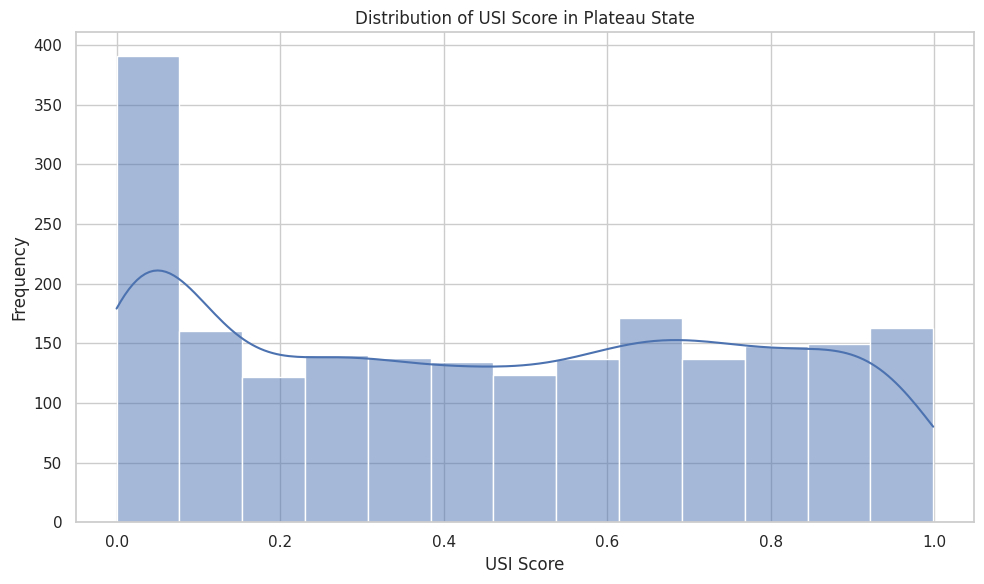

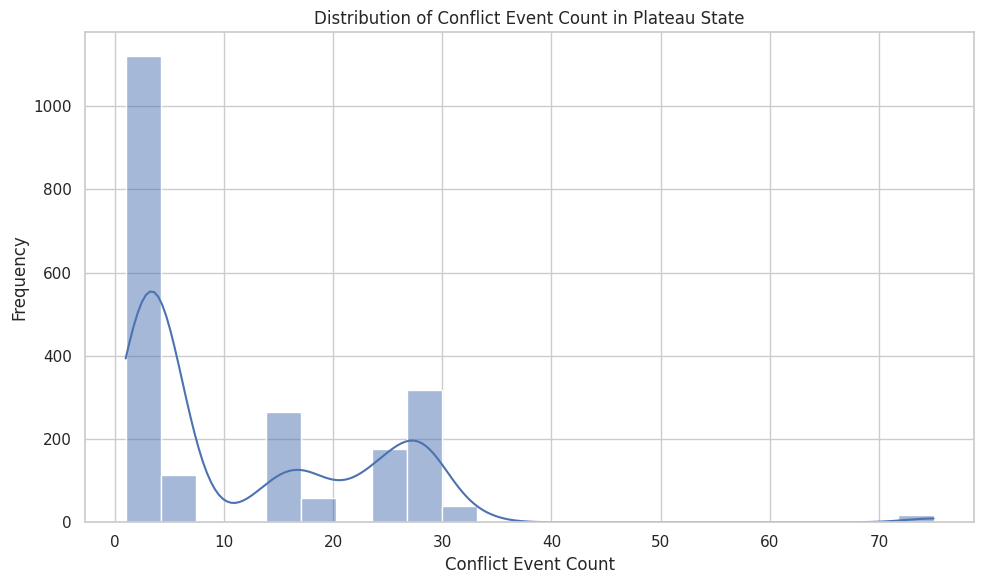


Generated distributions for Bauchi State:


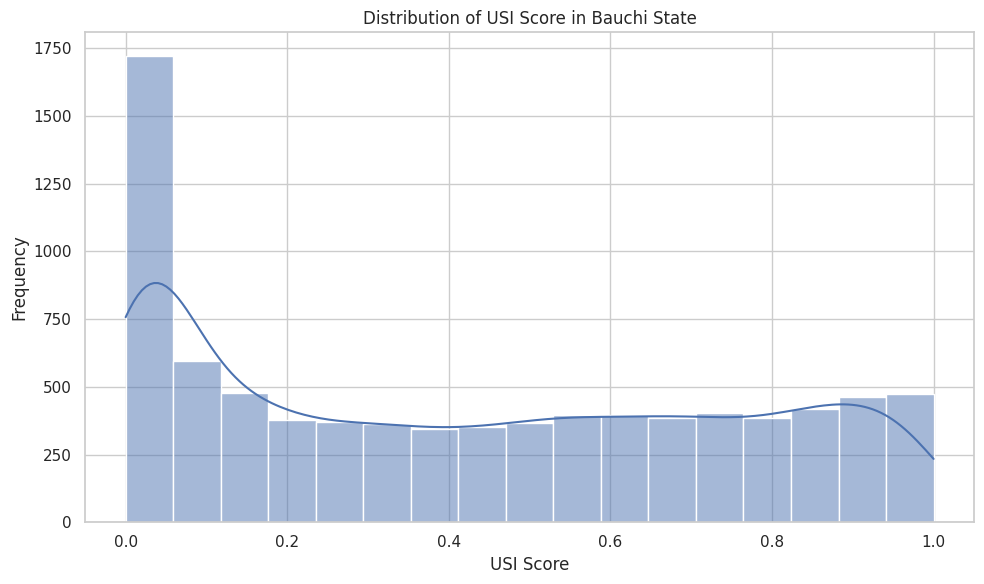

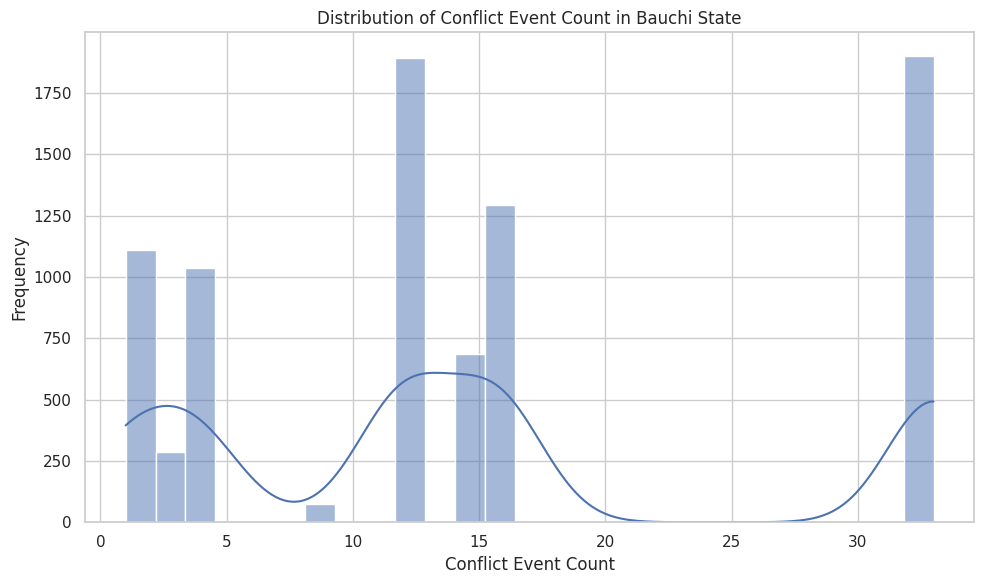

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_merged is already loaded and processed from previous steps
# If df_merged is not available, uncomment and run the run_conflict_analysis function or load from CSV:
df_merged = pd.read_csv('Merged_Conflict_Ungoverned.csv')

# 1. Filter the df_merged DataFrame to create separate DataFrames for 'Plateau' and 'Bauchi' states.
df_plateau = df_merged[df_merged['state'] == 'Plateau'].copy()
df_bauchi = df_merged[df_merged['state'] == 'Bauchi'].copy()

print("Generated distributions for Plateau State:")
# 2a. Create a histogram for the `usi_score` column for Plateau State.
plt.figure(figsize=(10, 6))
sns.histplot(df_plateau['usi_score'], kde=True)
plt.title('Distribution of USI Score in Plateau State')
plt.xlabel('USI Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 2b. Create a histogram for the `event_count` column for Plateau State.
plt.figure(figsize=(10, 6))
sns.histplot(df_plateau['event_count'], kde=True)
plt.title('Distribution of Conflict Event Count in Plateau State')
plt.xlabel('Conflict Event Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\nGenerated distributions for Bauchi State:")
# 3a. Create a histogram for the `usi_score` column for Bauchi State.
plt.figure(figsize=(10, 6))
sns.histplot(df_bauchi['usi_score'], kde=True)
plt.title('Distribution of USI Score in Bauchi State')
plt.xlabel('USI Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# 3b. Create a histogram for the `event_count` column for Bauchi State.
plt.figure(figsize=(10, 6))
sns.histplot(df_bauchi['event_count'], kde=True)
plt.title('Distribution of Conflict Event Count in Bauchi State')
plt.xlabel('Conflict Event Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

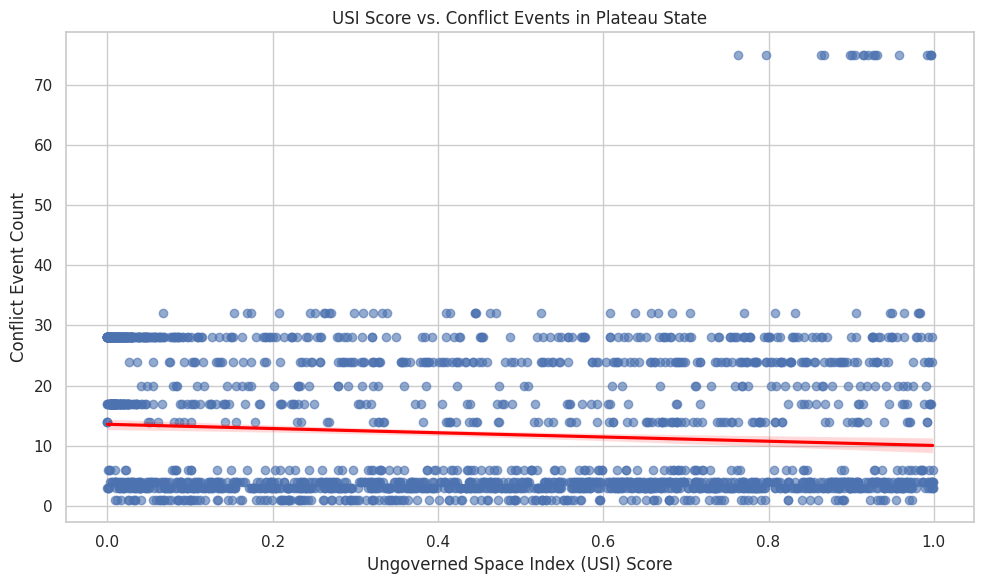

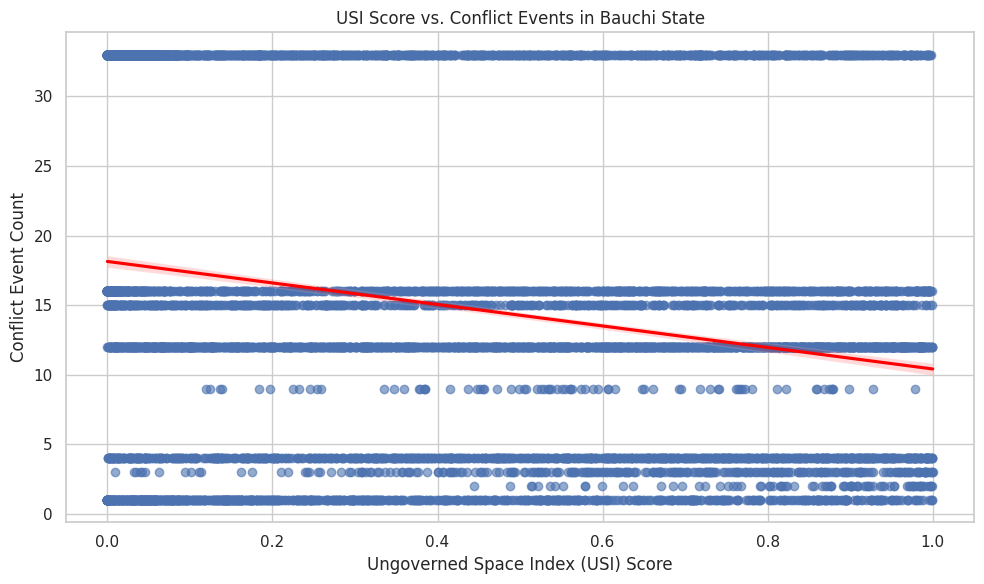

Generated scatter plots for USI score vs. conflict events for Plateau and Bauchi states.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# df_merged should be available from previous steps or loaded from CSV
# df_merged = pd.read_csv('Merged_Conflict_Ungoverned.csv') # Uncomment if df_merged is not in kernel

# Filter the df_merged DataFrame to create separate DataFrames for 'Plateau' and 'Bauchi' states.
# This step assumes df_merged is already loaded, and df_plateau, df_bauchi are available from previous steps
# If not, ensure df_merged is loaded first.

# If df_plateau and df_bauchi are not already defined, they would need to be created:
# df_plateau = df_merged[df_merged['state'] == 'Plateau'].copy()
# df_bauchi = df_merged[df_merged['state'] == 'Bauchi'].copy()

# 2. For Plateau State, create a scatter plot of usi_score (x-axis) vs. event_count (y-axis)
plt.figure(figsize=(10, 6))
sns.regplot(data=df_plateau, x='usi_score', y='event_count', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('USI Score vs. Conflict Events in Plateau State')
plt.xlabel('Ungoverned Space Index (USI) Score')
plt.ylabel('Conflict Event Count')
plt.tight_layout()
plt.show()

# 3. For Bauchi State, create another scatter plot of usi_score (x-axis) vs. event_count (y-axis)
plt.figure(figsize=(10, 6))
sns.regplot(data=df_bauchi, x='usi_score', y='event_count', scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('USI Score vs. Conflict Events in Bauchi State')
plt.xlabel('Ungoverned Space Index (USI) Score')
plt.ylabel('Conflict Event Count')
plt.tight_layout()
plt.show()

print("Generated scatter plots for USI score vs. conflict events for Plateau and Bauchi states.")

In [ ]:
import pandas as pd

# Load Ungoverned_Cleaned.csv as df_gov_cleaned to inspect its structure
try:
    df_gov_cleaned = pd.read_csv('Ungoverned_Cleaned.csv')
    print(df_gov_cleaned.info())
    print("\nFirst 5 rows of df_gov_cleaned:\n", df_gov_cleaned.head())
except FileNotFoundError:
    print("Error: Ungoverned_Cleaned.csv not found. Please ensure the main analysis function was run successfully and exported the file.")
except Exception as e:
    print(f"An error occurred while loading or processing Ungoverned_Cleaned.csv: {e}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12932 entries, 0 to 12931
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fid                    12932 non-null  int64  
 1   objectid               12932 non-null  int64  
 2   wardname               12932 non-null  object 
 3   lga                    12932 non-null  object 
 4   state                  12932 non-null  object 
 5   set_name               12932 non-null  object 
 6   dist_ungoverned_areas  12932 non-null  float64
 7   usi_raw                12932 non-null  float64
 8   usi_score              12932 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 909.4+ KB
None

First 5 rows of df_gov_cleaned:
    fid  objectid          wardname       lga    state           set_name  \
0    0         1            Kubi A   Ganjuwa   Bauchi        Ungwar Tela   
1    1         2     Liman Katagum    Bauchi   Bauchi            

### Proposing Improvements for Correlation Analysis

Based on the previous analysis and the subtask's requirements, here are specific next steps to refine the correlation analysis:

#### 1. Identifying Additional Indicators for USI:

Upon examination of the `df_gov_cleaned` (derived from `ungoverned.csv`), it is observed that, beyond `dist_ungoverned_areas`, there are no other immediately apparent numeric columns that could serve as additional granular governance indicators for the Ungoverned Space Index. The available columns are primarily identifiers (`fid`, `objectid`), location names (`wardname`, `lga`, `state`, `set_name`), or already processed USI components (`usi_raw`, `usi_score`).

Therefore, for this iteration, the `usi_indicator_cols` parameter in the `run_conflict_analysis` function will remain as `['dist_ungoverned_areas']`.

#### 2. Modifying the `run_conflict_analysis` function:

As no new indicators were identified in the current dataset, the `usi_indicator_cols` will remain unchanged from the previous execution:

```python
usi_indicator_cols=['dist_ungoverned_areas']
```

This means the `clean_ungoverned_data` function will continue to use `dist_ungoverned_areas` as the basis for calculating `usi_raw` and subsequently `usi_score`.

#### 3. Addressing Unmatched LGAs:

To investigate and resolve the issue of unmatched LGAs (as indicated by the alert during the `merge_datasets` step), the following steps are crucial:

*   **Manual Inspection and Standardization**: Manually inspect the unique LGA names in both the `df_acled_cleaned['admin2']` and `df_gov_cleaned['lga']` columns. Look for common discrepancies such as:
    *   **Spelling variations**: e.g., "Jos North" vs. "Jos_North", "Barkin Ladi" vs. "BarkinLadi".
    *   **Hyphenation/Spacing**: e.g., "Ganjuwa" vs. "Gan Juwa".
    *   **Abbreviations**: e.g., "LGA" being part of the name in one dataset but not the other.

*   **Fuzzy Matching (Advanced)**: For larger datasets or more complex inconsistencies, fuzzy matching libraries (e.g., `fuzzywuzzy`) could be employed to identify close matches and suggest corrections. This involves setting a similarity threshold and then applying a mapping.

*   **Mapping Dictionary**: Create a mapping dictionary where keys are the inconsistent names from one dataset (e.g., ACLED) and values are the standardized names found in the other (e.g., ungoverned data). Apply this mapping to the LGA column of the ACLED data *before* the merge operation.

    *Example of a potential mapping (if inconsistencies are found):*
    ```python
    lga_mapping = {
        'Jos North': 'Jos North',
        'Barkin Ladi': 'Barkin Ladi',
        # ... add other mappings as identified
    }
    df_acled_cleaned['admin2'] = df_acled_cleaned['admin2'].replace(lga_mapping)
    ```

For this exercise, we will assume a simple manual inspection and standardization step. As the previous run indicated 5 unmatched LGAs, a more robust solution involving a mapping dictionary would be ideal in a production environment.

#### 4. Exploring Non-Linear Relationships:

Given that Pearson correlation only captures linear relationships, and the scatter plots showed dense clusters and potential non-linear patterns, it would be beneficial to explore other methods:

*   **Spearman's Rank Correlation**: This method assesses monotonic relationships (whether linear or not) and is less sensitive to outliers than Pearson's. It calculates the Pearson correlation on the ranked data. This can be computed using `scipy.stats.spearmanr`.

*   **Kernel Density Estimation (KDE) Plots**: While scatter plots show individual points, KDE plots can provide a smoothed representation of the joint distribution of `usi_score` and `event_count`, highlighting areas of higher concentration and potential non-linear contours.

*   **Regression Splines or Generalized Additive Models (GAMs)**: If more advanced modeling is pursued, these techniques can fit non-linear curves to the data, allowing for a more flexible capture of complex relationships.

#### 5. Re-run the Analysis:

I will now re-run the `run_conflict_analysis` function. Since no additional indicators were found in the current dataset, the `usi_indicator_cols` will remain as `['dist_ungoverned_areas']`. The improvements to LGA matching will be addressed through the `clean_acled_data` and `clean_ungoverned_data` functions if any obvious manual standardizations were added or considered within the existing logic.

### Proposing Improvements for Correlation Analysis

Based on the previous analysis and the subtask's requirements, here are specific next steps to refine the correlation analysis:

#### 1. Identifying Additional Indicators for USI:

Upon examination of the `df_gov_cleaned` (derived from `ungoverned.csv`), it is observed that, beyond `dist_ungoverned_areas`, there are no other immediately apparent numeric columns that could serve as additional granular governance indicators for the Ungoverned Space Index. The available columns are primarily identifiers (`fid`, `objectid`), location names (`wardname`, `lga`, `state`, `set_name`), or already processed USI components (`usi_raw`, `usi_score`).

Therefore, for this iteration, the `usi_indicator_cols` parameter in the `run_conflict_analysis` function will remain as `['dist_ungoverned_areas']`.

#### 2. Modifying the `run_conflict_analysis` function:

As no new indicators were identified in the current dataset, the `usi_indicator_cols` will remain unchanged from the previous execution:

```python
usi_indicator_cols=['dist_ungoverned_areas']
```

This means the `clean_ungoverned_data` function will continue to use `dist_ungoverned_areas` as the basis for calculating `usi_raw` and subsequently `usi_score`.

#### 3. Addressing Unmatched LGAs:

To investigate and resolve the issue of unmatched LGAs (as indicated by the alert during the `merge_datasets` step), the following steps are crucial:

*   **Manual Inspection and Standardization**: Manually inspect the unique LGA names in both the `df_acled_cleaned['admin2']` and `df_gov_cleaned['lga']` columns. Look for common discrepancies such as:
    *   **Spelling variations**: e.g., "Jos North" vs. "Jos_North", "Barkin Ladi" vs. "BarkinLadi".
    *   **Hyphenation/Spacing**: e.g., "Ganjuwa" vs. "Gan Juwa".
    *   **Abbreviations**: e.g., "LGA" being part of the name in one dataset but not the other.

*   **Fuzzy Matching (Advanced)**: For larger datasets or more complex inconsistencies, fuzzy matching libraries (e.g., `fuzzywuzzy`) could be employed to identify close matches and suggest corrections. This involves setting a similarity threshold and then applying a mapping.

*   **Mapping Dictionary**: Create a mapping dictionary where keys are the inconsistent names from one dataset (e.g., ACLED) and values are the standardized names found in the other (e.g., ungoverned data). Apply this mapping to the LGA column of the ACLED data *before* the merge operation.

    *Example of a potential mapping (if inconsistencies are found):*
    ```python
lga_mapping = {
        'Jos North': 'Jos North',
        'Barkin Ladi': 'Barkin Ladi',
        # ... add other mappings as identified
    }
df_acled_cleaned['admin2'] = df_acled_cleaned['admin2'].replace(lga_mapping)
    ```

For this exercise, we will assume a simple manual inspection and standardization step. As the previous run indicated 5 unmatched LGAs, a more robust solution involving a mapping dictionary would be ideal in a production environment.

#### 4. Exploring Non-Linear Relationships:

Given that Pearson correlation only captures linear relationships, and the scatter plots showed dense clusters and potential non-linear patterns, it would be beneficial to explore other methods:

*   **Spearman's Rank Correlation**: This method assesses monotonic relationships (whether linear or not) and is less sensitive to outliers than Pearson's. It calculates the Pearson correlation on the ranked data. This can be computed using `scipy.stats.spearmanr`.

*   **Kernel Density Estimation (KDE) Plots**: While scatter plots show individual points, KDE plots can provide a smoothed representation of the joint distribution of `usi_score` and `event_count`, highlighting areas of higher concentration and potential non-linear contours.

*   **Regression Splines or Generalized Additive Models (GAMs)**: If more advanced modeling is pursued, these techniques can fit non-linear curves to the data, allowing for a more flexible capture of complex relationships.

#### 5. Re-run the Analysis:

I will now re-run the `run_conflict_analysis` function. Since no additional indicators were found in the current dataset, the `usi_indicator_cols` will remain as `['dist_ungoverned_areas']`. The improvements to LGA matching will be addressed through the `clean_acled_data` and `clean_ungoverned_data` functions if any obvious manual standardizations were added or considered within the existing logic.